In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.ensemble._iforest import _average_path_length
import shap
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_columns', None)

# Loading combined fbref/ transfermarkt data

In [2]:
df = pd.read_parquet(os.path.join('data', 'fbref_tm_combined.parquet'))

In [3]:
# Drop some negative columns that you might not want to identify players based on, e.g. number of yellow cards.
# penalties are rare so they tend to show up a lot in the outliers so removed for showing more interesting things
to_drop = ['performance_off', 'performance_crdy', 'performance_2crdy', 'performance_crdr', 'performance_fls',
           'performance_og', 'performance_pkcon', 'performance_pkwon', 'standard_fk', 'pass_types_fk', 'vs_dribbles_att',
           'outcomes_off', 'outcomes_out', 'outcomes_int', 'outcomes_blocks', 'standard_pk', 'playing_time_mn/mp', 'short_att',
           'pass_types_press', 'body_parts_right', 'body_parts_other', 'body_parts_head', 'a-xa', 'expected_np:g-xg',
           'aerial_duels_lost', 'carries_mis', 'carries_dis', 'err', 'standard_pkatt']
df.drop(to_drop, axis='columns', inplace=True)
# drop gca_types_gca_og_for as usually very low (mostly 0, but ocassionally 1 or 2)
# df.drop('gca_types_og', axis='columns', inplace=True)

# Drop centre backs / goalkeepers

Centre-back stats are notoriously hard and goalkeepers are judged differently so we drop them here.

In [4]:
mask_remove = (((df.position_tm == 'Centre-Back') | (df.position_tm == 'Goalkeeper')) &
               ((df.pos.str.contains('GK')) | (df.pos.str.contains('DF'))))
df = df[~mask_remove].copy()

# Drop players with fewer than 675 minutes played over last 3 years

This is an arbitrary cut-off point (around 7.5 games)

In [5]:
# commented out as already done in the 05_merge_transfermarkt_and_fbref notebook
#df = df[df.playing_time_min >= 675].copy()
#df.reset_index(drop=True, inplace=True)

# Add a code for the transfermarkt position

Note there is some disagreement between fbref and transfermarkt positions but it is broadly the same

In [6]:
df.loc[df.position_tm.str.contains('Midfield'), 'position_code'] = 0
df.loc[df.position_tm.str.contains('Back'), 'position_code'] = 1
df.loc[df.position_tm.str.contains('Striker'), 'position_code'] = 2
df.loc[df.position_tm.str.contains('Winger'), 'position_code'] = 2
df.loc[df.position_tm.str.contains('Forward'), 'position_code'] = 2

# Remove one player (Salva Ferrer) whose data is mostly missing

In [7]:
df = df[df.player_tm != 'Salva Ferrer'].copy()

# Reset the index

In [8]:
df.reset_index(drop=True, inplace=True)

# Check for highly correlated columns and drop them

In [9]:
corr_cols = ['pass_types_live', 'medium_att', 'total_att', 'receiving_rec', 'long_att', 'medium_cmp%', 'pass_types_crs',
             'touches_def_pen',  'tackles_tkl', 'vs_dribbles_past','blocks_pass',  'body_parts_ti',  'tackles_mid_3rd', 
             'prog', 'expected_xg','standard_sh',  'standard_g/sot',  'expected_g-xg', 'kp', 'sca_types_passlive',
             'team_success_+/-','gca_types_passlive', 'team_success_ong', 'dribbles_#pl', 'carries_totdist', 'medium_cmp',
             'total_cmp','tkl+int', 'team_success_(xg)_onxg', 'standard_sot', 'height_ground', 'touches_mid_3rd',
             'corner_kicks_in', 'corner_kicks_out', 'corner_kicks_str', 'touches_def_3rd', 'team_success_onga', 'dribbles_succ',
             'gca_gca','gca_types_passdead', 'sca_sca', 'standard_gls', 'ast', 'pass_types_dead', 'receiving_rec%',
             'gca_types_drib', 'gca_types_sh', 'gca_types_fld', 'short_cmp%', 'total_totdist', 'total_cmp%', 'height_low',
             # decided to get rid of gca_types_def as all the other gca are gone and I am 
             # thinking this is not as correlated with sca_types_def as there are relatively fewer
             # sca_types_def so there is more variance in the goals
             'gca_types_def',
             'expected_npxg+xa', 'performance_g-pk',  'touches_att_pen', 'carries_1/3', 'carries_prgdist',
             'long_cmp', 'touches_live', 'dribbles_att', 'pass_types_ck', 'pressures_press', 'touches_touches']

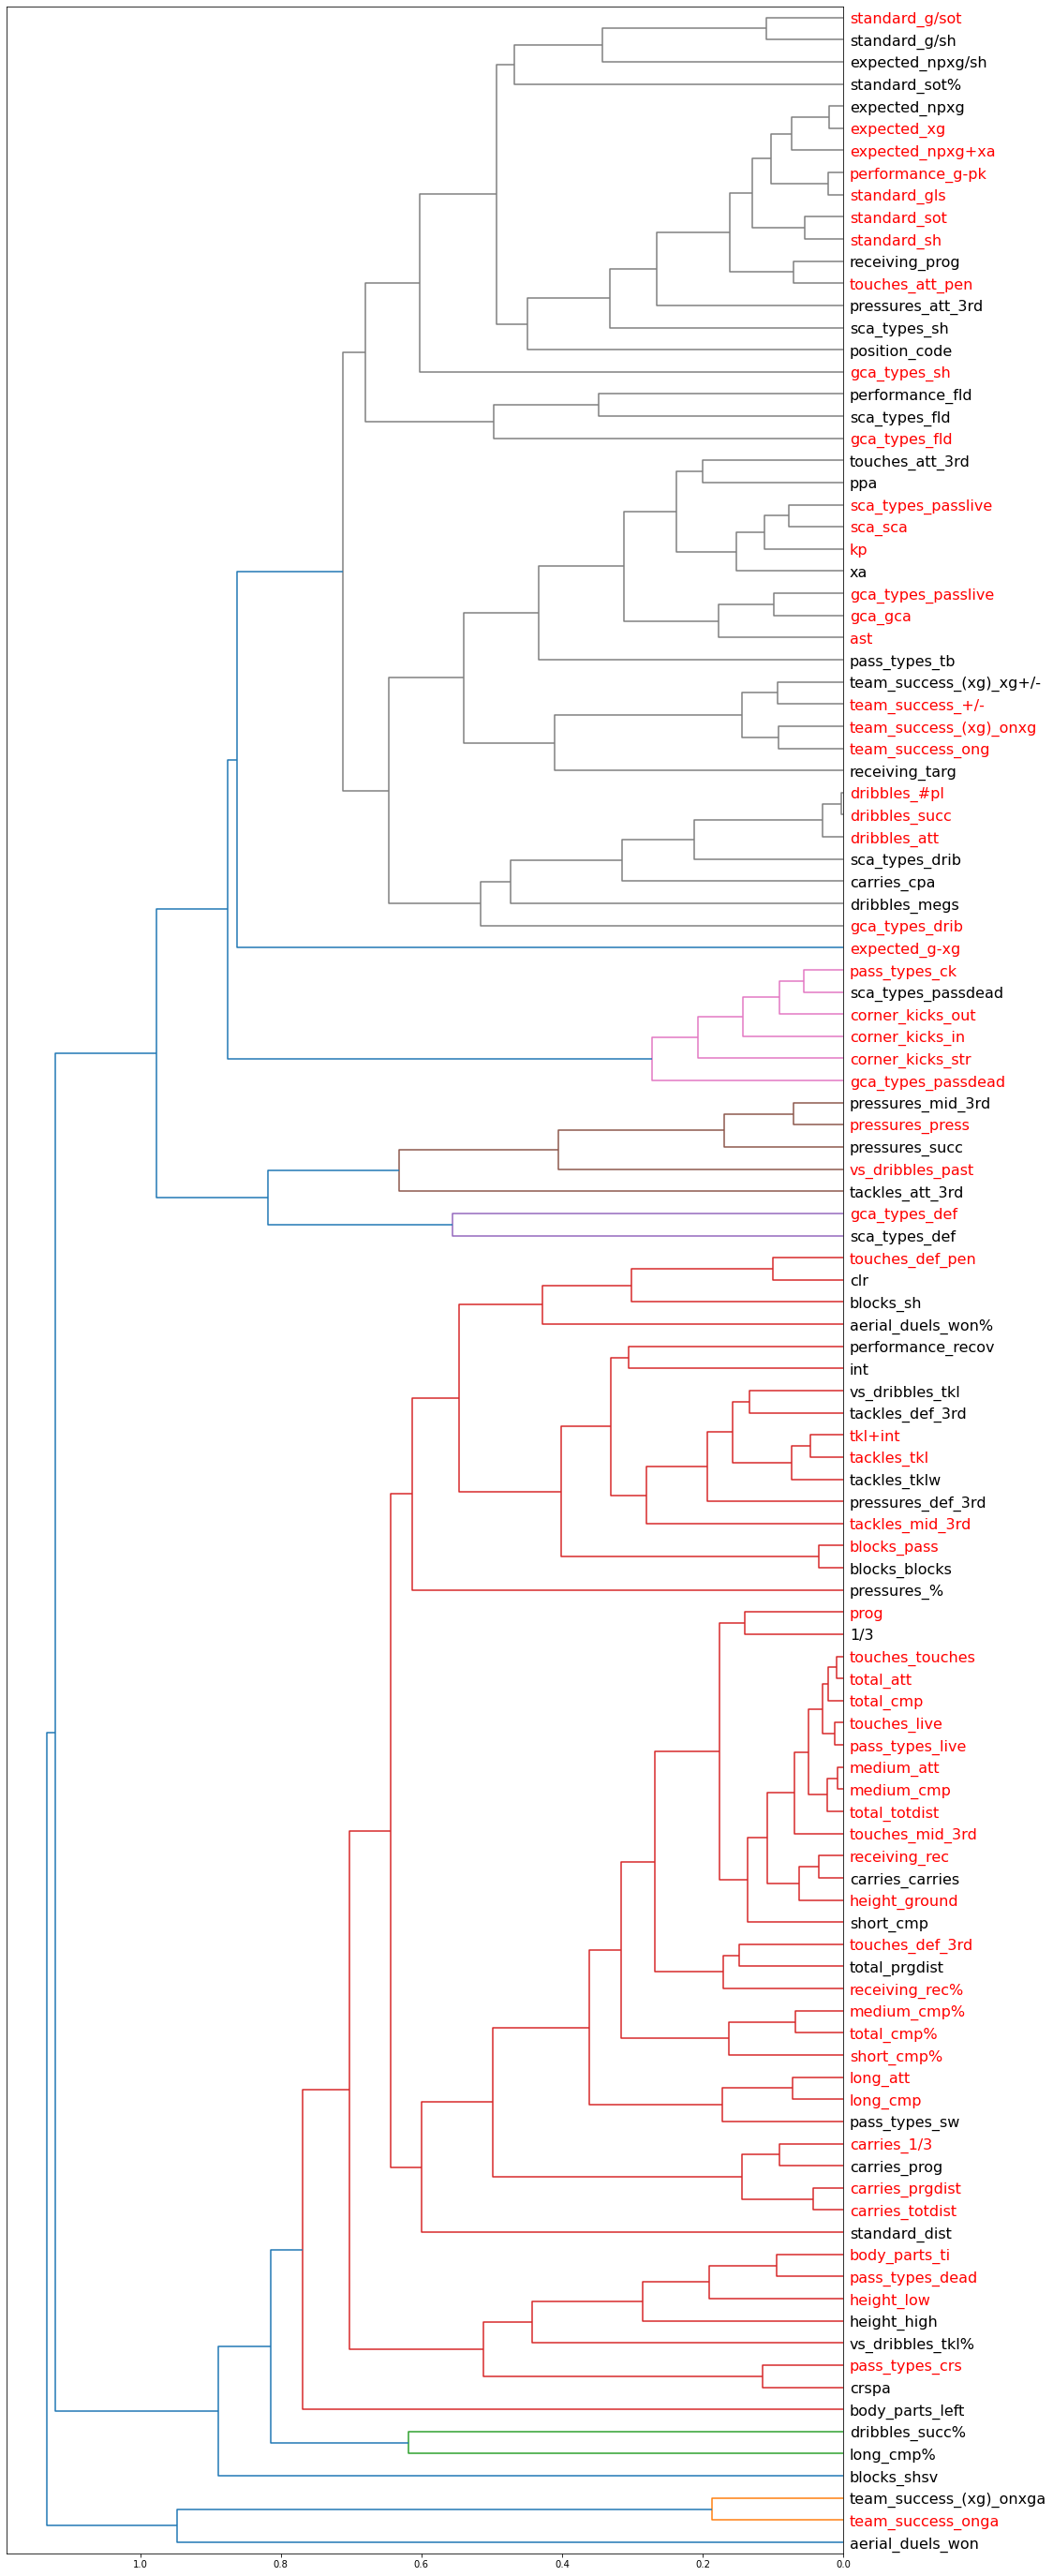

In [10]:
# https://stackoverflow.com/questions/34175462/dendrogram-using-pandas-and-scipy
corr_condensed = squareform(1 - df[df.columns[29:]].corr())
z = linkage(corr_condensed, method='average')
fig, ax = plt.subplots(figsize=(16, 50))
labels = list(df[df.columns[29:]].columns)
dend = dendrogram(z, orientation='left', labels=labels, leaf_font_size=16, ax=ax)
for label in ax.get_yticklabels():
    if label.get_text() in corr_cols:
        label.set_color('red')

In [11]:
df.drop(corr_cols, axis='columns', inplace=True)

In [12]:
print('Columns left:', len(df.columns[29:]))
list(df.columns[29:])

Columns left: 51


['team_success_(xg)_onxga',
 'team_success_(xg)_xg+/-',
 'tackles_tklw',
 'tackles_def_3rd',
 'tackles_att_3rd',
 'vs_dribbles_tkl',
 'pressures_succ',
 'pressures_def_3rd',
 'pressures_mid_3rd',
 'pressures_att_3rd',
 'blocks_blocks',
 'blocks_sh',
 'blocks_shsv',
 'int',
 'clr',
 'sca_types_passdead',
 'sca_types_drib',
 'sca_types_sh',
 'sca_types_fld',
 'sca_types_def',
 'performance_fld',
 'performance_recov',
 'aerial_duels_won',
 'total_prgdist',
 'short_cmp',
 'xa',
 '1/3',
 'ppa',
 'crspa',
 'pass_types_tb',
 'pass_types_sw',
 'height_high',
 'body_parts_left',
 'touches_att_3rd',
 'dribbles_megs',
 'carries_carries',
 'carries_prog',
 'carries_cpa',
 'receiving_targ',
 'receiving_prog',
 'expected_npxg',
 'standard_dist',
 'vs_dribbles_tkl%',
 'pressures_%',
 'aerial_duels_won%',
 'long_cmp%',
 'dribbles_succ%',
 'standard_g/sh',
 'expected_npxg/sh',
 'standard_sot%',
 'position_code']

Rename columns to more descriptive names

In [13]:
rename_cols = {'team_success_(xg)_onxga': 'xG allowed by team while on pitch',               
               'team_success_(xg)_xg+/-': 'xG scored minus allowed by team while on pitch',               
               'tackles_tklw': 'tackles won',
               'tackles_def_3rd': 'tackles (def 3rd)',
               'tackles_att_3rd': 'tackles (att 3rd)',
               'vs_dribbles_tkl': 'dribblers tackled',
               'pressures_succ': 'successful pressures',               
               'pressures_def_3rd': 'pressures (def 3rd)',
               'pressures_mid_3rd': 'pressures (mid 3rd)',
               'pressures_att_3rd': 'pressures (att 3rd)',
               'blocks_blocks': 'blocks',
               'blocks_sh': 'shots blocked',
               'blocks_shsv': 'shots blocked (on-target)',
               'int': 'interceptions',
               'clr': 'clearances',
               'sca_types_passdead': 'dead-ball pass leading to a shot attempt',
               'sca_types_drib': 'dribbles leading to a shot attempt',
               'sca_types_sh': 'shots leading to another shot attempt',
               'sca_types_fld': 'fouls drawn leading to a shot attempt',
               'sca_types_def': 'defensive actions leading to a shot attempt',
               'performance_fld': 'fouls drawn',
               'performance_recov': 'ball recoveries',
               'aerial_duels_won': 'aerial duels won',
               'total_prgdist': 'progressive passing distance',
               'short_cmp': 'short passes completed (#)',               
               'xa': 'xG assisted',    
               '1/3': 'passes into final third',
               'ppa': 'passes into penalty area',               
               'crspa': 'crosses into penalty area',
               'pass_types_tb': 'through balls',
               'pass_types_sw': 'switches',
               'height_high': 'high passes (#)',
               'body_parts_left': 'left foot pass attempts (#)',
               'touches_att_3rd': 'touches (# att 3rd)',
               'dribbles_megs': 'nutmegs',
               'carries_carries': 'carries (#)',
               'carries_prog': 'carries progressive distance',              
               'carries_cpa': 'carries into penalty area',
               'receiving_targ': 'target of attempted pass (#)',
               'receiving_prog': 'progressive passes received (#)',
               'expected_npxg': 'xG (non-penalty)',
               'standard_dist': 'shot distance (average)',
               'vs_dribbles_tkl%': '% of dribblers tackled',
               'pressures_%': '% of pressures successful',
               'aerial_duels_won%': '% of aerials won',
               'long_cmp%': '% of long passes completed',
               'dribbles_succ%': '% of dribbles successful',
               'standard_g/sh': 'goals per shot',
               'expected_npxg/sh': 'xG per shot (non-penalty)',
               'standard_sot%': '% of shots on target',
               'position_code': 'position'}
df.rename(rename_cols, axis=1, inplace=True)

# Change some values as we don't want to flag people as outliers for their poor stats (truncate stats for bottom quantile if more is better or top quantile if fewer is better)

In [14]:
X = df[df.columns[29:]]
X_copy = X.copy() # Store copy before modifying
X = X.fillna(0)
cols_fewer_better = ['xG allowed by team while on pitch', 'shot distance (average)']
cols_more_better = list(set(X.columns) - set(cols_fewer_better) - set(['position']))
# for goals allowed stats if in the top 50% change the value
value_1 = 0.5
mask1 = X[cols_fewer_better] > X[cols_fewer_better].quantile(value_1)
# for other stats is in the bottom 40% change value
value_2 = 0.4
mask2 = X[cols_more_better] < X[cols_more_better].quantile(value_2)
mask = pd.concat([mask1, mask2], axis='columns')
quantile_values = pd.concat([X[cols_fewer_better].quantile(value_1), X[cols_more_better].quantile(value_2)])
X.mask(mask, quantile_values, axis='columns', inplace=True)
# replace a couple of average distances that are zero with the maximum distance
# so we don't flag them up as outliers (they had zero shots)
max_dist = X['shot distance (average)'].max()
X.loc[X['shot distance (average)'] == 0, 'shot distance (average)'] = max_dist

# Find outliers using isolation forest

In [15]:
clf = IsolationForest(random_state=42, contamination=0.1)
y_pred = clf.fit(X)
forest_score = clf.score_samples(X)

# Calculate shap values (to explain the outliers)

In [16]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
df_shap = pd.DataFrame(shap_values, columns=X.columns)

# Round to 1/2 decimal places

In [17]:
cols_round_int = ['progressive passing distance', 'short passes completed (#)',
                  'high passes (#)', 'left foot pass attempts (#)', 'touches (# att 3rd)',
                  'carries (#)', 'carries progressive distance', 'target of attempted pass (#)',
                  'progressive passes received (#)', 'shot distance (average)',
                  '% of dribblers tackled', '% of pressures successful',
                  '% of aerials won', '% of long passes completed', '% of dribbles successful', '% of shots on target']
other_cols = list(set(X_copy.columns) - set(cols_round_int) - set(['position']))
X_copy[cols_round_int] = X_copy[cols_round_int].round(1)
X_copy[other_cols] = X_copy[other_cols].round(2)

# Calculate percentiles for each player based on position (back, midfield, forward)

In [18]:
X_position_percentile = ((X_copy
                         .fillna(0)
                         .groupby('position')[X_copy.columns[:-1]]
                         .rank(pct=True) * 100).round(0).astype(np.int32))
X_position_percentile['position'] = np.nan
# reverse where better is lower
X_position_percentile['xG allowed by team while on pitch'] = 100 - X_position_percentile['xG allowed by team while on pitch']
X_position_percentile['shot distance (average)'] = 100 - X_position_percentile['shot distance (average)']
# if zero shot distance (typically didn't take any shots) set the percentile to zero
X_position_percentile.loc[X_copy['shot distance (average)'] == 0, 'shot distance (average)'] = 0

# Get lower (0.05) and upper (0.95) quantile values for each position

In [19]:
upper = X_copy.groupby('position')[X_copy.columns[:-1]].quantile(0.95)
upper.index = ['midfield_upper', 'back_upper', 'forward_upper']
lower = X_copy.groupby('position')[X_copy.columns[:-1]].quantile(0.05)
lower.index = ['midfield_lower', 'back_lower', 'forward_lower']
# swap xG allowed as lower is better!
swap_col = 'xG allowed by team while on pitch'
swap_upper = upper[swap_col].values.copy()
swap_lower = lower[swap_col].values.copy()
lower[swap_col] = swap_upper
upper[swap_col] = swap_lower
# concatenate
df_quantile = pd.concat([lower, upper])
df_quantile.sort_index(inplace=True)

# Get the column names contributing to the the smallest (most negative) difference and their values

In [20]:
# https://stackoverflow.com/questions/48764923/find-the-column-name-which-has-the-2nd-maximum-value-for-each-row-pandas
sort_arr = np.argsort(df_shap.values, axis=1)
df_stat_name = pd.DataFrame(np.array(df_shap.columns)[sort_arr], index=df_shap.index,
                            columns=[f'stat_{i}_name' for i in range(1, sort_arr.shape[1] + 1)])
# then get values
sort_arr = (sort_arr.T + (np.arange(0, sort_arr.shape[0]) * sort_arr.shape[1])).T
df_stat_values = pd.DataFrame(X_copy.values.ravel()[sort_arr].reshape(X_copy.shape),
                              columns=[f'stat_{i}_value' for i in range(1, sort_arr.shape[1] + 1)])
df_percentile_values = pd.DataFrame(X_position_percentile.values.ravel()[sort_arr].reshape(X_position_percentile.shape),
                                    columns=[f'stat_{i}_percentile' for i in range(1, sort_arr.shape[1] + 1)])

# merge them together
df_stat_values = df_stat_name.merge(df_stat_values, left_index=True, right_index=True)
df_stat_values = df_stat_values.merge(df_percentile_values, left_index=True, right_index=True)
# reorder the columns so it goes stat name then value, stat name then value, etc.
num_col = sort_arr.shape[1]
col_order = np.repeat(np.arange(num_col), 3) + np.tile(np.array([0, num_col, num_col * 2]), num_col)
col_order = df_stat_values.columns[col_order]
df_stat_values = df_stat_values[col_order].copy()

# Create final dataframe

In [21]:
keep_cols = list(df.columns[:29])
keep_cols.append('position')
df = df[keep_cols].copy()
position_rename = {0: 'midfield', 1: 'back', 2: 'forward'}
df['position'] = df.position.map(position_rename)
df['outlier_score'] = forest_score
df = df.merge(df_stat_values, left_index=True, right_index=True, validate='1:1')

# Backs where their position contributes towards them being an outlier

In [22]:
index_interesting_defenders = df_shap[(df['position'] == 'back') & (df_shap['position'] < 0)].index
df[df.index.isin(index_interesting_defenders)]

,number_tm,player_tm,position_tm,height_tm,foot_tm,joined_tm,contract_expires_tm,market_value_euro_millions_tm,league_tm,player_link_tm,year_tm,dob_tm,squad_tm,age_at_2021_07_01_tm,player_link_fbref,player,nation,pos,squad,comp,match_link,90s,born,playing_time_mp,playing_time_min,starts_starts,starts_compl,subs_subs,subs_unsub,position,outlier_score,stat_1_name,stat_1_value,stat_1_percentile,stat_2_name,stat_2_value,stat_2_percentile,stat_3_name,stat_3_value,stat_3_percentile,stat_4_name,stat_4_value,stat_4_percentile,stat_5_name,stat_5_value,stat_5_percentile,stat_6_name,stat_6_value,stat_6_percentile,stat_7_name,stat_7_value,stat_7_percentile,stat_8_name,stat_8_value,stat_8_percentile,stat_9_name,stat_9_value,stat_9_percentile,stat_10_name,stat_10_value,stat_10_percentile,stat_11_name,stat_11_value,stat_11_percentile,stat_12_name,stat_12_value,stat_12_percentile,stat_13_name,stat_13_value,stat_13_percentile,stat_14_name,stat_14_value,stat_14_percentile,stat_15_name,stat_15_value,stat_15_percentile,stat_16_name,stat_16_value,stat_16_percentile,stat_17_name,stat_17_value,stat_17_percentile,stat_18_name,stat_18_value,stat_18_percentile,stat_19_name,stat_19_value,stat_19_percentile,stat_20_name,stat_20_value,stat_20_percentile,stat_21_name,stat_21_value,stat_21_percentile,stat_22_name,stat_22_value,stat_22_percentile,stat_23_name,stat_23_value,stat_23_percentile,stat_24_name,stat_24_value,stat_24_percentile,stat_25_name,stat_25_value,stat_25_percentile,stat_26_name,stat_26_value,stat_26_percentile,stat_27_name,stat_27_value,stat_27_percentile,stat_28_name,stat_28_value,stat_28_percentile,stat_29_name,stat_29_value,stat_29_percentile,stat_30_name,stat_30_value,stat_30_percentile,stat_31_name,stat_31_value,stat_31_percentile,stat_32_name,stat_32_value,stat_32_percentile,stat_33_name,stat_33_value,stat_33_percentile,stat_34_name,stat_34_value,stat_34_percentile,stat_35_name,stat_35_value,stat_35_percentile,stat_36_name,stat_36_value,stat_36_percentile,stat_37_name,stat_37_value,stat_37_percentile,stat_38_name,stat_38_value,stat_38_percentile,stat_39_name,stat_39_value,stat_39_percentile,stat_40_name,stat_40_value,stat_40_percentile,stat_41_name,stat_41_value,stat_41_percentile,stat_42_name,stat_42_value,stat_42_percentile,stat_43_name,stat_43_value,stat_43_percentile,stat_44_name,stat_44_value,stat_44_percentile,stat_45_name,stat_45_value,stat_45_percentile,stat_46_name,stat_46_value,stat_46_percentile,stat_47_name,stat_47_value,stat_47_percentile,stat_48_name,stat_48_value,stat_48_percentile,stat_49_name,stat_49_value,stat_49_percentile,stat_50_name,stat_50_value,stat_50_percentile,stat_51_name,stat_51_value,stat_51_percentile
2,17.0,Felix Agu,Left-Back,1.80,right,2020-07-01,2024-06-30,2.5,2. Bundesliga,/felix-agu/profil/spieler/393512,2020,1999-09-27,Werder Bremen,21.8,/en/players/cb6d81b3/Felix-Agu,Felix Agu,de GER,DF,Werder Bremen,de Bundesliga,/en/players/cb6d81b3/matchlogs/2020-2021/summa...,7.8,1999.0,15.0,701.0,8.0,NaN,7.0,16.0,back,-0.463812,dribblers tackled,1.67,99.0,pressures (def 3rd),11.04,99.0,fouls drawn,3.34,100.0,tackles won,2.05,97.0,interceptions,2.70,100.0,tackles (def 3rd),1.54,78.0,successful pressures,6.16,98.0,clearances,2.95,63.0,tackles (att 3rd),0.51,98.0,% of dribblers tackled,54.20,86.0,pressures (att 3rd),3.98,97.0,progressive passing distance,146.70,1.0,shots blocked,0.38,79.0,crosses into penalty area,0.38,36.0,position,1.00,NaN,high passes (#),8.20,9.0,blocks,2.05,59.0,ball recoveries,8.35,41.0,aerial duels won,1.54,73.0,fouls drawn leading to a shot attempt,0.13,88.0,carries (#),27.20,11.0,pressures (mid 3rd),8.09,99.0,passes into final third,1.16,1.0,carries progressive distance,1.90,1.0,switches,0.64,17.0,% of dribbles successful,33.30,1.0,% of aerials won,46.20,34.0,% of shots on target,NaN,24.0,% of pressures successful,26.70,18.0,xG per shot (non-penalty),NaN,24.0,dribbles leading to a shot attempt,0.13,83.0,passes into penalty area,0.51,10.0,xG scored minus allowed by team while on pitch,-0.

# Midfield where their position contributes most towards them being an outlier

In [23]:
index_interesting_defenders = df_shap[(df['position'] == 'midfield') &
                                      (df_shap['position'] < 0)].sort_values('position').index
df[df.index.isin(index_interesting_defenders)].head(10)

,number_tm,player_tm,position_tm,height_tm,foot_tm,joined_tm,contract_expires_tm,market_value_euro_millions_tm,league_tm,player_link_tm,year_tm,dob_tm,squad_tm,age_at_2021_07_01_tm,player_link_fbref,player,nation,pos,squad,comp,match_link,90s,born,playing_time_mp,playing_time_min,starts_starts,starts_compl,subs_subs,subs_unsub,position,outlier_score,stat_1_name,stat_1_value,stat_1_percentile,stat_2_name,stat_2_value,stat_2_percentile,stat_3_name,stat_3_value,stat_3_percentile,stat_4_name,stat_4_value,stat_4_percentile,stat_5_name,stat_5_value,stat_5_percentile,stat_6_name,stat_6_value,stat_6_percentile,stat_7_name,stat_7_value,stat_7_percentile,stat_8_name,stat_8_value,stat_8_percentile,stat_9_name,stat_9_value,stat_9_percentile,stat_10_name,stat_10_value,stat_10_percentile,stat_11_name,stat_11_value,stat_11_percentile,stat_12_name,stat_12_value,stat_12_percentile,stat_13_name,stat_13_value,stat_13_percentile,stat_14_name,stat_14_value,stat_14_percentile,stat_15_name,stat_15_value,stat_15_percentile,stat_16_name,stat_16_value,stat_16_percentile,stat_17_name,stat_17_value,stat_17_percentile,stat_18_name,stat_18_value,stat_18_percentile,stat_19_name,stat_19_value,stat_19_percentile,stat_20_name,stat_20_value,stat_20_percentile,stat_21_name,stat_21_value,stat_21_percentile,stat_22_name,stat_22_value,stat_22_percentile,stat_23_name,stat_23_value,stat_23_percentile,stat_24_name,stat_24_value,stat_24_percentile,stat_25_name,stat_25_value,stat_25_percentile,stat_26_name,stat_26_value,stat_26_percentile,stat_27_name,stat_27_value,stat_27_percentile,stat_28_name,stat_28_value,stat_28_percentile,stat_29_name,stat_29_value,stat_29_percentile,stat_30_name,stat_30_value,stat_30_percentile,stat_31_name,stat_31_value,stat_31_percentile,stat_32_name,stat_32_value,stat_32_percentile,stat_33_name,stat_33_value,stat_33_percentile,stat_34_name,stat_34_value,stat_34_percentile,stat_35_name,stat_35_value,stat_35_percentile,stat_36_name,stat_36_value,stat_36_percentile,stat_37_name,stat_37_value,stat_37_percentile,stat_38_name,stat_38_value,stat_38_percentile,stat_39_name,stat_39_value,stat_39_percentile,stat_40_name,stat_40_value,stat_40_percentile,stat_41_name,stat_41_value,stat_41_percentile,stat_42_name,stat_42_value,stat_42_percentile,stat_43_name,stat_43_value,stat_43_percentile,stat_44_name,stat_44_value,stat_44_percentile,stat_45_name,stat_45_value,stat_45_percentile,stat_46_name,stat_46_value,stat_46_percentile,stat_47_name,stat_47_value,stat_47_percentile,stat_48_name,stat_48_value,stat_48_percentile,stat_49_name,stat_49_value,stat_49_percentile,stat_50_name,stat_50_value,stat_50_percentile,stat_51_name,stat_51_value,stat_51_percentile
0,6.0,Laurent Abergel,Defensive Midfield,1.70,right,2019-07-26,2025-06-30,2.500,Ligue 1,/laurent-abergel/profil/spieler/238626,2020,1993-02-01,Lorient,28.4,/en/players/31626657/Laurent-Abergel,Laurent Abergel,fr FRA,MF,Lorient,fr Ligue 1,/en/players/31626657/matchlogs/2020-2021/summa...,32.9,1993.0,38.0,2963.0,32.0,NaN,6.0,0.0,midfield,-0.504439,tackles won,3.28,100.0,dribblers tackled,1.61,100.0,successful pressures,8.17,98.0,tackles (def 3rd),1.97,99.0,shots blocked (on-target),0.03,97.0,pressures (mid 3rd),16.37,99.0,defensive actions leading to a shot attempt,0.15,96.0,pressures (def 3rd),9.81,97.0,tackles (att 3rd),0.49,94.0,% of long passes completed,69.20,61.0,shots leading to another shot attempt,0.15,82.0,goals per shot,0.10,81.0,position,0.00,NaN,% of dribbles successful,71.00,71.0,interceptions,1.40,81.0,ball recoveries,9.05,43.0,passes into final third,3.43,48.0,% of dribblers tackled,29.60,46.0,clearances,0.40,8.0,carries (#),41.40,55.0,% of pressures successful,28.10,50.0,fouls drawn,1.15,43.0,shots blocked,0.18,39.0,% of aerials won,29.60,13.0,switches,1.61,56.0,% of shots on target,33.30,78.0,high passes (#),6.70,36.0,short passes completed (#),16.10,43.0,carries progressive distance,3.20,25.0,aerial duels won,0.24,4.0,dribbles leading to a shot attempt,0.03,23.0,fouls drawn leading to a shot

# Wingers/ forwards where their position contributes most towards them being an outlier

In [24]:
index_interesting_defenders = df_shap[(df['position'] == 'forward') &
                                      (df_shap['position'] < 0)].sort_values('position').index
df[df.index.isin(index_interesting_defenders)].head(10)

,number_tm,player_tm,position_tm,height_tm,foot_tm,joined_tm,contract_expires_tm,market_value_euro_millions_tm,league_tm,player_link_tm,year_tm,dob_tm,squad_tm,age_at_2021_07_01_tm,player_link_fbref,player,nation,pos,squad,comp,match_link,90s,born,playing_time_mp,playing_time_min,starts_starts,starts_compl,subs_subs,subs_unsub,position,outlier_score,stat_1_name,stat_1_value,stat_1_percentile,stat_2_name,stat_2_value,stat_2_percentile,stat_3_name,stat_3_value,stat_3_percentile,stat_4_name,stat_4_value,stat_4_percentile,stat_5_name,stat_5_value,stat_5_percentile,stat_6_name,stat_6_value,stat_6_percentile,stat_7_name,stat_7_value,stat_7_percentile,stat_8_name,stat_8_value,stat_8_percentile,stat_9_name,stat_9_value,stat_9_percentile,stat_10_name,stat_10_value,stat_10_percentile,stat_11_name,stat_11_value,stat_11_percentile,stat_12_name,stat_12_value,stat_12_percentile,stat_13_name,stat_13_value,stat_13_percentile,stat_14_name,stat_14_value,stat_14_percentile,stat_15_name,stat_15_value,stat_15_percentile,stat_16_name,stat_16_value,stat_16_percentile,stat_17_name,stat_17_value,stat_17_percentile,stat_18_name,stat_18_value,stat_18_percentile,stat_19_name,stat_19_value,stat_19_percentile,stat_20_name,stat_20_value,stat_20_percentile,stat_21_name,stat_21_value,stat_21_percentile,stat_22_name,stat_22_value,stat_22_percentile,stat_23_name,stat_23_value,stat_23_percentile,stat_24_name,stat_24_value,stat_24_percentile,stat_25_name,stat_25_value,stat_25_percentile,stat_26_name,stat_26_value,stat_26_percentile,stat_27_name,stat_27_value,stat_27_percentile,stat_28_name,stat_28_value,stat_28_percentile,stat_29_name,stat_29_value,stat_29_percentile,stat_30_name,stat_30_value,stat_30_percentile,stat_31_name,stat_31_value,stat_31_percentile,stat_32_name,stat_32_value,stat_32_percentile,stat_33_name,stat_33_value,stat_33_percentile,stat_34_name,stat_34_value,stat_34_percentile,stat_35_name,stat_35_value,stat_35_percentile,stat_36_name,stat_36_value,stat_36_percentile,stat_37_name,stat_37_value,stat_37_percentile,stat_38_name,stat_38_value,stat_38_percentile,stat_39_name,stat_39_value,stat_39_percentile,stat_40_name,stat_40_value,stat_40_percentile,stat_41_name,stat_41_value,stat_41_percentile,stat_42_name,stat_42_value,stat_42_percentile,stat_43_name,stat_43_value,stat_43_percentile,stat_44_name,stat_44_value,stat_44_percentile,stat_45_name,stat_45_value,stat_45_percentile,stat_46_name,stat_46_value,stat_46_percentile,stat_47_name,stat_47_value,stat_47_percentile,stat_48_name,stat_48_value,stat_48_percentile,stat_49_name,stat_49_value,stat_49_percentile,stat_50_name,stat_50_value,stat_50_percentile,stat_51_name,stat_51_value,stat_51_percentile
16,9.0,Saïd Benrahma,Left Winger,1.72,right,2021-01-29,2026-06-30,22.0,Premier League,/said-benrahma/profil/spieler/290532,2020,1995-08-10,West Ham,25.9,/en/players/5a04fd92/Said-Benrahma,Saïd Benrahma,dz ALG,"FW,MF",West Ham,eng Premier League,/en/players/5a04fd92/matchlogs/2020-2021/summa...,15.5,1995.0,30.0,1391.0,14.0,NaN,16.0,2.0,forward,-0.430140,nutmegs,0.45,99.0,xG assisted,0.28,96.0,carries into penalty area,0.97,69.0,carries progressive distance,8.00,90.0,through balls,0.19,78.0,tackles (att 3rd),0.39,83.0,position,2.00,NaN,tackles won,1.36,94.0,passes into penalty area,1.42,81.0,defensive actions leading to a shot attempt,0.06,63.0,touches (# att 3rd),24.00,69.0,fouls drawn leading to a shot attempt,0.06,7.0,carries (#),40.40,84.0,passes into final third,2.65,92.0,% of shots on target,31.40,16.0,interceptions,0.84,87.0,blocks,0.97,44.0,crosses into penalty area,0.39,82.0,pressures (att 3rd),4.14,8.0,dribbles leading to a shot attempt,0.19,40.0,% of dribbles successful,57.80,57.0,pressures (mid 3rd),9.19,73.0,% of dribblers tackled,28.60,73.0,shots blocked (on-target),0.00,48.0,aerial duels won,0.19,4.0,xG scored minus allowed by team while on pitch,0.11,64.0,% of aerials won,16.70,5.0,fouls drawn,0.97,18.0,progressive passes received (#),5.60,12.0,high passes (#),4.70,50.0,ball recoveries,8.02,96.

# Sort by the score

In [25]:
df.sort_values('outlier_score', inplace=True)
df.reset_index(drop=True, inplace=True)

# Rename some columns

In [26]:
df.rename({'number_tm': 'number_transfermarkt',
           'player_tm': 'player_name_transfermarkt',
           'player': 'player_name_fbref',
           'dob_tm': 'dob_transfermarkt',
           'age_at_2021_07_01_tm': 'age_years_at_2021_07_01_transfermarkt',
           'position_tm': 'position_transfermarkt',
           'pos': 'position_fbref',
           'height_tm': 'height_transfermarkt',
           'foot_tm': 'foot_transfermarkt',
           'squad_tm': 'squad_transfermarkt', 
           'league_tm': 'league_transfermarkt',
           'joined_tm': 'joined_transfermarkt',
           'contract_expires_tm': 'contract_expires_transfermarkt',
           'market_value_euro_millions_tm': 'market_value_euros_millions_transfermarkt', 
           'year_tm': 'year_of_valuation_transfermarkt',
           'player_link_tm': 'player_link_transfermarkt',
           'player_link_fbref': 'player_link_fbref',
           'nation': 'nation_fbref',
           'squad': 'squad_fbref',
           'comp': 'comp_fbref',
           'match_link': 'match_link_fbref',
           'born': 'born_fbref'},
          axis='columns', inplace=True)

# Show top 30 outliers

In [27]:
df.head(30)

,number_transfermarkt,player_name_transfermarkt,position_transfermarkt,height_transfermarkt,foot_transfermarkt,joined_transfermarkt,contract_expires_transfermarkt,market_value_euros_millions_transfermarkt,league_transfermarkt,player_link_transfermarkt,year_of_valuation_transfermarkt,dob_transfermarkt,squad_transfermarkt,age_years_at_2021_07_01_transfermarkt,player_link_fbref,player_name_fbref,nation_fbref,position_fbref,squad_fbref,comp_fbref,match_link_fbref,90s,born_fbref,playing_time_mp,playing_time_min,starts_starts,starts_compl,subs_subs,subs_unsub,position,outlier_score,stat_1_name,stat_1_value,stat_1_percentile,stat_2_name,stat_2_value,stat_2_percentile,stat_3_name,stat_3_value,stat_3_percentile,stat_4_name,stat_4_value,stat_4_percentile,stat_5_name,stat_5_value,stat_5_percentile,stat_6_name,stat_6_value,stat_6_percentile,stat_7_name,stat_7_value,stat_7_percentile,stat_8_name,stat_8_value,stat_8_percentile,stat_9_name,stat_9_value,stat_9_percentile,stat_10_name,stat_10_value,stat_10_percentile,stat_11_name,stat_11_value,stat_11_percentile,stat_12_name,stat_12_value,stat_12_percentile,stat_13_name,stat_13_value,stat_13_percentile,stat_14_name,stat_14_value,stat_14_percentile,stat_15_name,stat_15_value,stat_15_percentile,stat_16_name,stat_16_value,stat_16_percentile,stat_17_name,stat_17_value,stat_17_percentile,stat_18_name,stat_18_value,stat_18_percentile,stat_19_name,stat_19_value,stat_19_percentile,stat_20_name,stat_20_value,stat_20_percentile,stat_21_name,stat_21_value,stat_21_percentile,stat_22_name,stat_22_value,stat_22_percentile,stat_23_name,stat_23_value,stat_23_percentile,stat_24_name,stat_24_value,stat_24_percentile,stat_25_name,stat_25_value,stat_25_percentile,stat_26_name,stat_26_value,stat_26_percentile,stat_27_name,stat_27_value,stat_27_percentile,stat_28_name,stat_28_value,stat_28_percentile,stat_29_name,stat_29_value,stat_29_percentile,stat_30_name,stat_30_value,stat_30_percentile,stat_31_name,stat_31_value,stat_31_percentile,stat_32_name,stat_32_value,stat_32_percentile,stat_33_name,stat_33_value,stat_33_percentile,stat_34_name,stat_34_value,stat_34_percentile,stat_35_name,stat_35_value,stat_35_percentile,stat_36_name,stat_36_value,stat_36_percentile,stat_37_name,stat_37_value,stat_37_percentile,stat_38_name,stat_38_value,stat_38_percentile,stat_39_name,stat_39_value,stat_39_percentile,stat_40_name,stat_40_value,stat_40_percentile,stat_41_name,stat_41_value,stat_41_percentile,stat_42_name,stat_42_value,stat_42_percentile,stat_43_name,stat_43_value,stat_43_percentile,stat_44_name,stat_44_value,stat_44_percentile,stat_45_name,stat_45_value,stat_45_percentile,stat_46_name,stat_46_value,stat_46_percentile,stat_47_name,stat_47_value,stat_47_percentile,stat_48_name,stat_48_value,stat_48_percentile,stat_49_name,stat_49_value,stat_49_percentile,stat_50_name,stat_50_value,stat_50_percentile,stat_51_name,stat_51_value,stat_51_percentile
0,10.0,Neymar,Left Winger,1.75,right,2017-08-03,2025-06-30,100.0,Ligue 1,/neymar/profil/spieler/68290,2020,1992-02-05,Paris S-G,29.4,/en/players/69384e5d/Neymar,Neymar,br BRA,"MF,FW",Paris S-G,fr Ligue 1,/en/players/69384e5d/matchlogs/2020-2021/summa...,46.3,1992.0,50.0,4172.0,46.0,22.0,4.0,0.0,forward,-0.649075,nutmegs,0.67,100.0,passes into penalty area,4.23,100.0,through balls,1.10,100.0,xG scored minus allowed by team while on pitch,1.54,100.0,fouls drawn,4.03,100.0,dribbles leading to a shot attempt,0.84,99.0,target of attempted pass (#),83.60,100.0,xG (non-penalty),0.52,96.0,passes into final third,7.44,100.0,carries (#),73.00,100.0,carries progressive distance,13.80,100.0,short passes completed (#),27.20,99.0,xG assisted,0.40,99.0,touches (# att 3rd),46.70,100.0,progressive passes received (#),12.20,97.0,fouls drawn leading to a shot attempt,0.73,99.0,xG allowed by team while on pitch,0.92,96.0,carries into penalty area,1.36,86.0,shots leading to another shot attempt,0.30,88.0,progressive passing distance,314.80,100.0,xG per shot (non-penalty),0.15,77.0,dead-ball pass leadin

# Show top 30 outliers aged 26 or under and valued at 15 mill or under

In [28]:
df[(df.age_years_at_2021_07_01_transfermarkt <= 26) & (df.market_value_euros_millions_transfermarkt <= 15)].head(30)

,number_transfermarkt,player_name_transfermarkt,position_transfermarkt,height_transfermarkt,foot_transfermarkt,joined_transfermarkt,contract_expires_transfermarkt,market_value_euros_millions_transfermarkt,league_transfermarkt,player_link_transfermarkt,year_of_valuation_transfermarkt,dob_transfermarkt,squad_transfermarkt,age_years_at_2021_07_01_transfermarkt,player_link_fbref,player_name_fbref,nation_fbref,position_fbref,squad_fbref,comp_fbref,match_link_fbref,90s,born_fbref,playing_time_mp,playing_time_min,starts_starts,starts_compl,subs_subs,subs_unsub,position,outlier_score,stat_1_name,stat_1_value,stat_1_percentile,stat_2_name,stat_2_value,stat_2_percentile,stat_3_name,stat_3_value,stat_3_percentile,stat_4_name,stat_4_value,stat_4_percentile,stat_5_name,stat_5_value,stat_5_percentile,stat_6_name,stat_6_value,stat_6_percentile,stat_7_name,stat_7_value,stat_7_percentile,stat_8_name,stat_8_value,stat_8_percentile,stat_9_name,stat_9_value,stat_9_percentile,stat_10_name,stat_10_value,stat_10_percentile,stat_11_name,stat_11_value,stat_11_percentile,stat_12_name,stat_12_value,stat_12_percentile,stat_13_name,stat_13_value,stat_13_percentile,stat_14_name,stat_14_value,stat_14_percentile,stat_15_name,stat_15_value,stat_15_percentile,stat_16_name,stat_16_value,stat_16_percentile,stat_17_name,stat_17_value,stat_17_percentile,stat_18_name,stat_18_value,stat_18_percentile,stat_19_name,stat_19_value,stat_19_percentile,stat_20_name,stat_20_value,stat_20_percentile,stat_21_name,stat_21_value,stat_21_percentile,stat_22_name,stat_22_value,stat_22_percentile,stat_23_name,stat_23_value,stat_23_percentile,stat_24_name,stat_24_value,stat_24_percentile,stat_25_name,stat_25_value,stat_25_percentile,stat_26_name,stat_26_value,stat_26_percentile,stat_27_name,stat_27_value,stat_27_percentile,stat_28_name,stat_28_value,stat_28_percentile,stat_29_name,stat_29_value,stat_29_percentile,stat_30_name,stat_30_value,stat_30_percentile,stat_31_name,stat_31_value,stat_31_percentile,stat_32_name,stat_32_value,stat_32_percentile,stat_33_name,stat_33_value,stat_33_percentile,stat_34_name,stat_34_value,stat_34_percentile,stat_35_name,stat_35_value,stat_35_percentile,stat_36_name,stat_36_value,stat_36_percentile,stat_37_name,stat_37_value,stat_37_percentile,stat_38_name,stat_38_value,stat_38_percentile,stat_39_name,stat_39_value,stat_39_percentile,stat_40_name,stat_40_value,stat_40_percentile,stat_41_name,stat_41_value,stat_41_percentile,stat_42_name,stat_42_value,stat_42_percentile,stat_43_name,stat_43_value,stat_43_percentile,stat_44_name,stat_44_value,stat_44_percentile,stat_45_name,stat_45_value,stat_45_percentile,stat_46_name,stat_46_value,stat_46_percentile,stat_47_name,stat_47_value,stat_47_percentile,stat_48_name,stat_48_value,stat_48_percentile,stat_49_name,stat_49_value,stat_49_percentile,stat_50_name,stat_50_value,stat_50_percentile,stat_51_name,stat_51_value,stat_51_percentile
4,59.0,Aleksey Miranchuk,Attacking Midfield,1.82,left,2020-09-04,2024-06-30,15.0,Serie A,/aleksey-miranchuk/profil/spieler/255450,2020,1995-10-17,Atalanta,25.7,/en/players/a9aa0d1d/Aleksei-Miranchuk,Aleksei Miranchuk,ru RUS,"FW,MF",Atalanta,it Serie A,/en/players/a9aa0d1d/matchlogs/2020-2021/summa...,7.5,1995.0,25.0,675.0,4.0,NaN,21.0,8.0,midfield,-0.599633,tackles (att 3rd),0.80,100.0,goals per shot,0.25,100.0,passes into penalty area,2.80,100.0,touches (# att 3rd),38.50,99.0,progressive passes received (#),11.20,100.0,xG assisted,0.33,100.0,left foot pass attempts (#),46.50,96.0,% of pressures successful,38.10,100.0,carries into penalty area,1.33,99.0,carries progressive distance,8.70,95.0,fouls drawn leading to a shot attempt,0.40,98.0,fouls drawn,2.67,97.0,% of shots on target,43.80,95.0,ball recoveries,9.87,57.0,% of dribblers tackled,62.50,100.0,successful pressures,6.00,71.0,target of attempted pass (#),64.00,91.0,short passes completed (#),22.70,84.0,carries (#),53.20,85.0,shot distance (average),15.70,89.0,xG (non-penalty),0.24,96.0,pressures (att 3rd),6.67,94.0,position,0

# Show older outliers with a low valuation

In [29]:
df[(df.market_value_euros_millions_transfermarkt < 5) & (df.age_years_at_2021_07_01_transfermarkt > 26) & 
   (df.age_years_at_2021_07_01_transfermarkt < 30)].head(15)

,number_transfermarkt,player_name_transfermarkt,position_transfermarkt,height_transfermarkt,foot_transfermarkt,joined_transfermarkt,contract_expires_transfermarkt,market_value_euros_millions_transfermarkt,league_transfermarkt,player_link_transfermarkt,year_of_valuation_transfermarkt,dob_transfermarkt,squad_transfermarkt,age_years_at_2021_07_01_transfermarkt,player_link_fbref,player_name_fbref,nation_fbref,position_fbref,squad_fbref,comp_fbref,match_link_fbref,90s,born_fbref,playing_time_mp,playing_time_min,starts_starts,starts_compl,subs_subs,subs_unsub,position,outlier_score,stat_1_name,stat_1_value,stat_1_percentile,stat_2_name,stat_2_value,stat_2_percentile,stat_3_name,stat_3_value,stat_3_percentile,stat_4_name,stat_4_value,stat_4_percentile,stat_5_name,stat_5_value,stat_5_percentile,stat_6_name,stat_6_value,stat_6_percentile,stat_7_name,stat_7_value,stat_7_percentile,stat_8_name,stat_8_value,stat_8_percentile,stat_9_name,stat_9_value,stat_9_percentile,stat_10_name,stat_10_value,stat_10_percentile,stat_11_name,stat_11_value,stat_11_percentile,stat_12_name,stat_12_value,stat_12_percentile,stat_13_name,stat_13_value,stat_13_percentile,stat_14_name,stat_14_value,stat_14_percentile,stat_15_name,stat_15_value,stat_15_percentile,stat_16_name,stat_16_value,stat_16_percentile,stat_17_name,stat_17_value,stat_17_percentile,stat_18_name,stat_18_value,stat_18_percentile,stat_19_name,stat_19_value,stat_19_percentile,stat_20_name,stat_20_value,stat_20_percentile,stat_21_name,stat_21_value,stat_21_percentile,stat_22_name,stat_22_value,stat_22_percentile,stat_23_name,stat_23_value,stat_23_percentile,stat_24_name,stat_24_value,stat_24_percentile,stat_25_name,stat_25_value,stat_25_percentile,stat_26_name,stat_26_value,stat_26_percentile,stat_27_name,stat_27_value,stat_27_percentile,stat_28_name,stat_28_value,stat_28_percentile,stat_29_name,stat_29_value,stat_29_percentile,stat_30_name,stat_30_value,stat_30_percentile,stat_31_name,stat_31_value,stat_31_percentile,stat_32_name,stat_32_value,stat_32_percentile,stat_33_name,stat_33_value,stat_33_percentile,stat_34_name,stat_34_value,stat_34_percentile,stat_35_name,stat_35_value,stat_35_percentile,stat_36_name,stat_36_value,stat_36_percentile,stat_37_name,stat_37_value,stat_37_percentile,stat_38_name,stat_38_value,stat_38_percentile,stat_39_name,stat_39_value,stat_39_percentile,stat_40_name,stat_40_value,stat_40_percentile,stat_41_name,stat_41_value,stat_41_percentile,stat_42_name,stat_42_value,stat_42_percentile,stat_43_name,stat_43_value,stat_43_percentile,stat_44_name,stat_44_value,stat_44_percentile,stat_45_name,stat_45_value,stat_45_percentile,stat_46_name,stat_46_value,stat_46_percentile,stat_47_name,stat_47_value,stat_47_percentile,stat_48_name,stat_48_value,stat_48_percentile,stat_49_name,stat_49_value,stat_49_percentile,stat_50_name,stat_50_value,stat_50_percentile,stat_51_name,stat_51_value,stat_51_percentile
52,92.0,Jean-Daniel Akpa Akpro,Central Midfield,1.80,right,2020-09-18,2024-06-30,3.5,Serie A,/jean-daniel-akpa-akpro/profil/spieler/170481,2020,1992-10-11,Lazio,28.7,/en/players/fdf4b948/Jean-Daniel-Akpa-Akpro,Jean-Daniel Akpa-Akpro,ci CIV,MF,Lazio,it Serie A,/en/players/fdf4b948/matchlogs/2020-2021/summa...,11.7,1992.0,32.0,1056.0,6.0,NaN,26.0,4.0,midfield,-0.522707,successful pressures,9.38,100.0,nutmegs,0.34,100.0,tackles won,2.39,97.0,defensive actions leading to a shot attempt,0.26,100.0,pressures (mid 3rd),15.17,98.0,shots blocked,0.51,93.0,pressures (def 3rd),9.12,94.0,blocks,2.81,100.0,pressures (att 3rd),5.88,90.0,% of long passes completed,73.50,76.0,% of dribbles successful,73.10,77.0,tackles (att 3rd),0.43,89.0,dribblers tackled,0.77,68.0,position,0.00,NaN,interceptions,1.53,88.0,shot distance (average),15.50,90.0,xG allowed by team while on pitch,1.13,79.0,xG scored minus allowed by team while on pitch,0.20,71.0,ball recoveries,7.93,24.0,through balls,0.17,75.0,progressive passes received (#),3.30,58.0,% of pressures successful,31.10,82.0,% of aerials won,50.00,63.0,pr

# Save to excel

In [30]:
df.to_excel(os.path.join('data', 'outliers.xlsx'))

In [31]:
df.to_parquet(os.path.join('data', 'outliers.parquet'))
df_quantile.to_parquet(os.path.join('data', 'quantiles.parquet'))